# Telecom Churn Analysis & Modeling

## Overview

This project utilizes a dataset of customers from the telecommunications company SyriaTel, analyzing the churn rate of customers (number of customers that stop doing business with the company) by identifying patterns amongst customer features. Additionally, several classification models are built and tuned, then compared to choose the best model for predicting whether customers will stop doing business.   

## Business Problem

The telecom company SyriaTel is concerned with their profits related to customer retention. They want to reduce the amount of money lost because of customers that don't remain with the company for very long. The task is to build a classifier to predict if a customer will soon stop doing business with SyriaTel, by looking for any predictable patterns. 

## Data Understanding

The dataset used for this project is a csv file ("churn_data.csv"), containing over 3,000 customer records and 21 columns. These columns include information on whether they have an international plan or voice mail plan, the totality of calls made and minutes spent on the phone, and the number of calls made to customer service. The target feature is the final column labeled "churn", a binary column indicating whether or not they stopped doing business with the company.  

### Import Libraries

First thing we did was import the necessary libraries for analysis, visualization, preprocessing data, and building models. 

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import log_loss, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE

In [2]:
#set a random state variable
STATE = 42

In [3]:
#load the dataset, column names are in the second row
df = pd.read_csv('churn_data.csv', header=1)

In [4]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
df.shape

(3333, 21)

In [6]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [7]:
#check the dtype of each column. There are no missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [8]:
#check for duplicates, which there are none
df.duplicated().sum()

0

In [9]:
#add column that combines the total domestic calls
total_dom_calls = df['total day calls'] + df['total eve calls'] + df['total night calls']
df.insert(7, 'total domestic calls', total_dom_calls)

In [10]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total domestic calls,total day minutes,total day calls,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,300,265.1,110,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,329,161.6,123,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,328,243.4,114,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,248,299.4,71,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,356,166.7,113,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [11]:
#add column that combines the total domestic minutes
total_dom_mins = df['total day minutes'] + df['total eve minutes'] + df['total night minutes']
df.insert(8, 'total domestic minutes', total_dom_mins)

In [12]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total domestic calls,total domestic minutes,total day minutes,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,300,707.2,265.1,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,329,611.5,161.6,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,328,527.2,243.4,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,248,558.2,299.4,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,356,501.9,166.7,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [13]:
#check the value counts of churn column
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [14]:
#convert the churn counts into percentages 
churn_rate = df['churn'].value_counts() / len(df['churn']) * 100 
churn_rate

False    85.508551
True     14.491449
Name: churn, dtype: float64

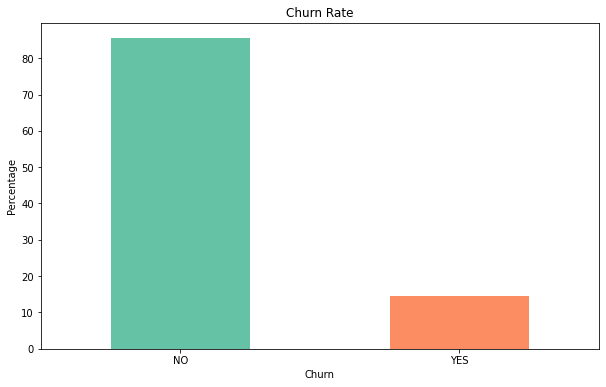

In [15]:
#plot the churn rate
fig, ax = plt.subplots(figsize=(10, 6)) 
colors = sns.color_palette('Set2')
churn_rate.plot(kind='bar', ax=ax, color=colors)
ax.set_xlabel('Churn')
ax.set_ylabel('Percentage')
ax.set_title('Churn Rate')
ax.set_xticklabels(['NO', 'YES'], rotation=0)
plt.show()

In [16]:
#check the value counts for area code
df['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

In [17]:
#separate categoric and numeric columns into variables
categoric = ['state', 'area code', 'voice mail plan', 'international plan']
numeric = []
for c in df.columns:
    if c not in categoric:
        numeric.append(c)

In [18]:
#remove phone number column from the numeric list
numeric.remove('phone number')

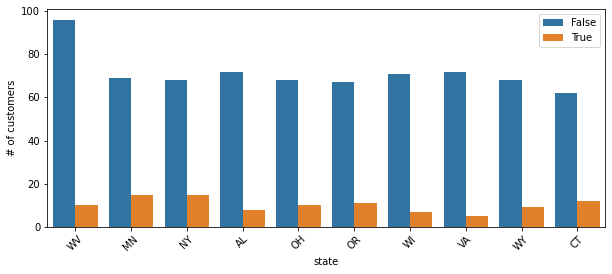

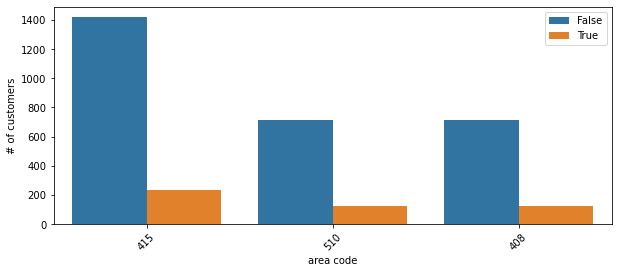

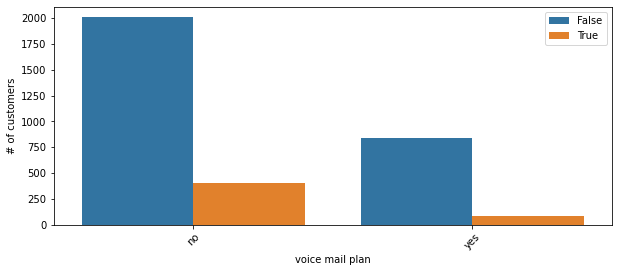

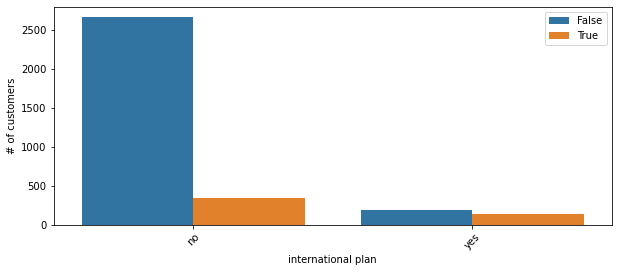

In [19]:
#graph the categoric columns and their churn outcomes
for cat in categoric:
    plt.figure(figsize=(10,4))
    sns.countplot(x=cat, hue="churn", data=df, order= df[cat].value_counts().iloc[0:10].index)
    plt.xticks(rotation=45)
    plt.ylabel('# of customers')
    plt.legend(loc="upper right")
    plt.show()

In [20]:
#group the customers who've dropped the company by state
churn_per_state = df.groupby('state')['churn'].sum().sort_values(ascending=False)
churn_per_state.head()

state
TX    18
NJ    18
MD    17
MI    16
NY    15
Name: churn, dtype: int64

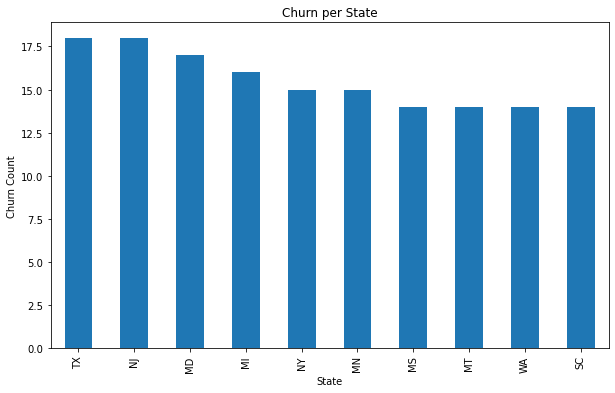

In [21]:
#graph the top 10 churned customers by state
plt.figure(figsize=(10, 6))
churn_per_state[:10].plot(kind='bar')

plt.xlabel('State')
plt.ylabel('Churn Count')
plt.title('Churn per State')

plt.show()

In [22]:
churn_rate_per_state = df.groupby('state')['churn'].mean().sort_values(ascending=False)
churn_rate_per_state.head()

state
CA    0.264706
NJ    0.264706
TX    0.250000
MD    0.242857
SC    0.233333
Name: churn, dtype: float64

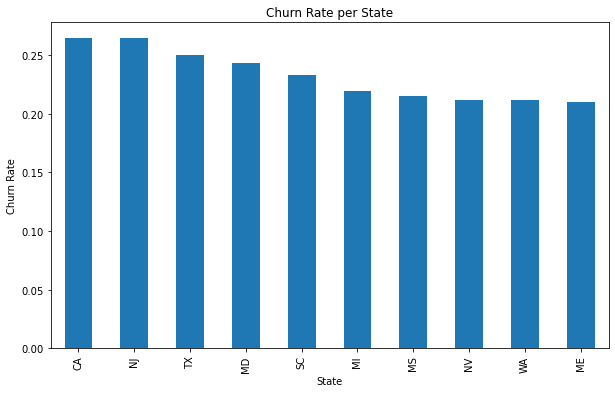

In [23]:
#graph the 10 highest churn rates by state
plt.figure(figsize=(10, 6))
churn_rate_per_state[:10].plot(kind='bar')

plt.xlabel('State')
plt.ylabel('Churn Rate')
plt.title('Churn Rate per State')

plt.show()

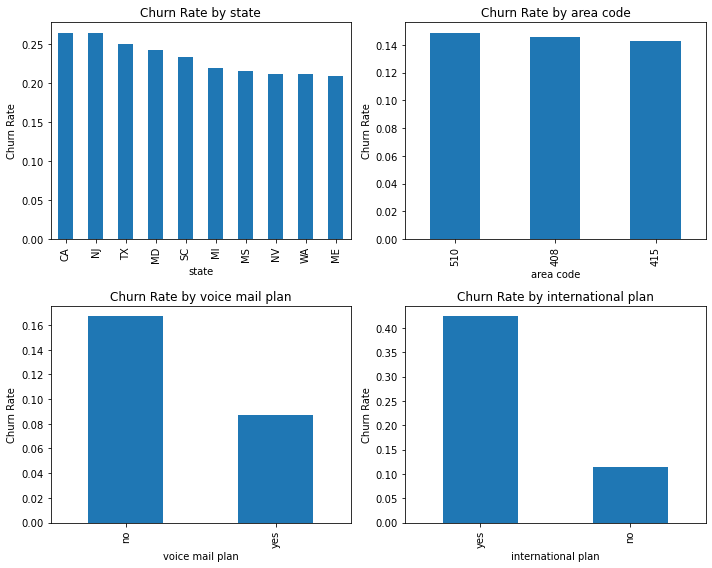

In [24]:
# Iterate over categorical columns
fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax = ax.ravel()
for i, column in enumerate(categoric):
    # Calculate the churn rate for each unique value in the column
    churn_rates = df.groupby(column)['churn'].mean().sort_values(ascending=False).head(10)

    # Graph the churn rates
    churn_rates.plot(kind='bar', ax=ax[i])
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(f'Churn Rate by {column}')
plt.tight_layout()
plt.show()

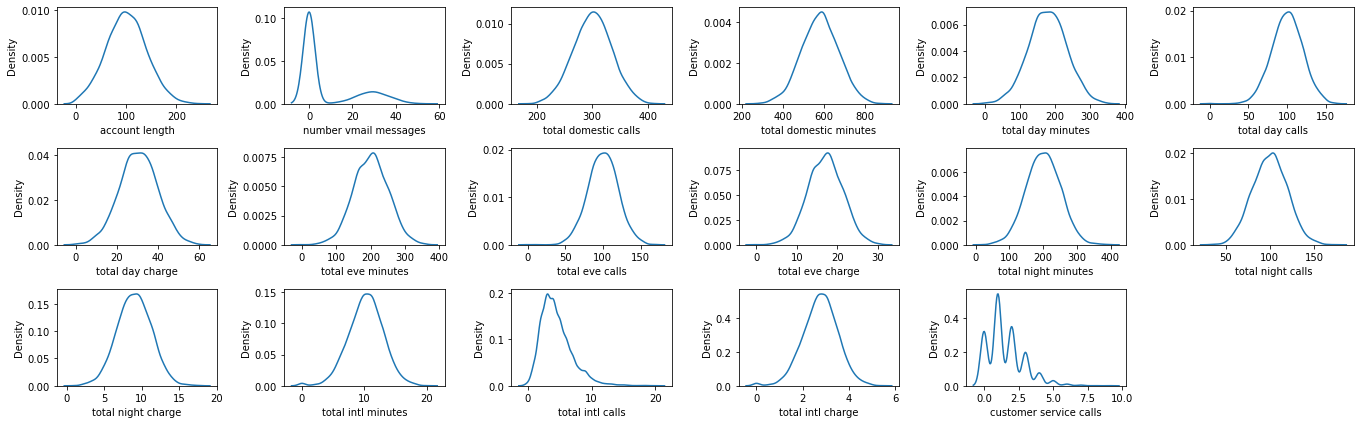

In [25]:
#check distribution curves of numeric columns
fig, ax = plt.subplots(len(numeric)//5,6,figsize=(19,6))
ax = ax.flatten()
for i, j in enumerate(numeric):
    if j != 'churn':
        sns.kdeplot(df[j],ax=ax[i]);
fig.delaxes(ax[-1])
plt.tight_layout()
plt.show()

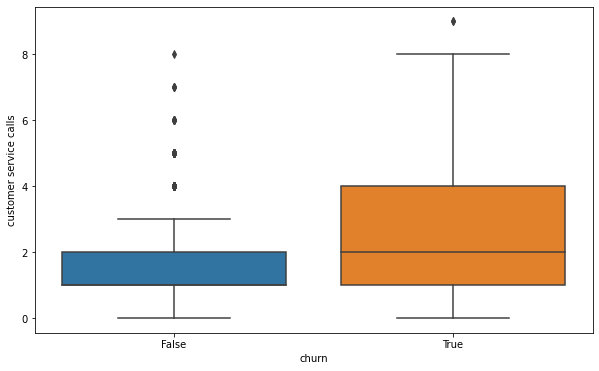

In [26]:
#graph a boxplot to check the typical number of customer service calls for customers that stay vs leave
plt.figure(figsize=(10,6))
sns.boxplot(x='churn', y='customer service calls', data=df)
plt.show()

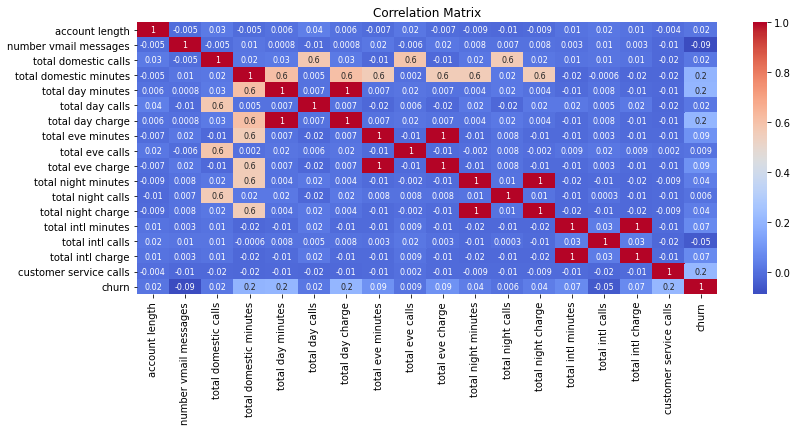

In [27]:
# Compute the correlation matrix
correlation_matrix = df[numeric].corr()

# Create a heatmap
plt.figure(figsize=(13, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.0g', annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

In [28]:
#drop the phone number column from the dataframe
df.drop(columns='phone number', inplace=True)
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total domestic calls,total domestic minutes,total day minutes,total day calls,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,no,yes,25,300,707.2,265.1,110,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,329,611.5,161.6,123,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,328,527.2,243.4,114,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,248,558.2,299.4,71,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,356,501.9,166.7,113,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [29]:
#call OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Extract the categorical columns and convert them to a separate DataFrame
df_categorical = df[categoric]

# Fit the categorical DataFrame 
ohe.fit(df_categorical)

# Create a new DataFrame with transformed encoded categorical columns
df_encoded = pd.DataFrame(data=ohe.transform(df_categorical), columns=ohe.get_feature_names(categoric),
    index=df_categorical.index)

# Drop the original categorical columns from the original DataFrame
df.drop(columns=categoric, inplace=True)

# Concatenate the encoded categorical columns with the original DataFrame
df = pd.concat([df, df_encoded], axis=1)

In [30]:
df.head()

,account length,number vmail messages,total domestic calls,total domestic minutes,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510,voice mail plan_no,voice mail plan_yes,international plan_no,international plan_yes
0,128,25,300,707.2,265.1,110,45.07,197.4,99,16.78,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,107,26,329,611.5,161.6,123,27.47,195.5,103,16.62,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,137,0,328,527.2,243.4,114,41.38,121.2,110,10.30,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,84,0,248,558.2,299.4,71,50.90,61.9,88,5.26,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,75,0,356,501.9,166.7,113,28.34,148.3,122,12.61,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [31]:
#check the value counts for account length
df['account length'].value_counts()

105    43
87     42
93     40
101    40
90     39
       ..
191     1
199     1
215     1
221     1
2       1
Name: account length, Length: 212, dtype: int64

In [32]:
# Instantiate StandardScaler
scaler = MinMaxScaler()
for i in df.select_dtypes(include=[np.number]).columns:
    df[i] = scaler.fit_transform(df[i].values.reshape(-1,1))

In [33]:
df.head()

,account length,number vmail messages,total domestic calls,total domestic minutes,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510,voice mail plan_no,voice mail plan_yes,international plan_no,international plan_yes
0,0.524793,0.490196,0.504505,0.717966,0.755701,0.666667,0.755701,0.542755,0.582353,0.542866,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.438017,0.509804,0.635135,0.558916,0.460661,0.745455,0.460597,0.537531,0.605882,0.537690,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.561983,0.000000,0.630631,0.418813,0.693843,0.690909,0.693830,0.333242,0.647059,0.333225,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.342975,0.000000,0.270270,0.470334,0.853478,0.430303,0.853454,0.170195,0.517647,0.170171,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.305785,0.000000,0.756757,0.376766,0.475200,0.684848,0.475184,0.407754,0.717647,0.407959,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [34]:
df.drop('account length', axis=1, inplace=True)

In [35]:
#set up datasets for modeling
X = df.drop(columns='churn')
y = df['churn']

In [36]:
#create a train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=STATE)

In [37]:
#create and fit a baseline logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

Train AUC: 0.8323643992391171
Test AUC: 0.8325641748942172


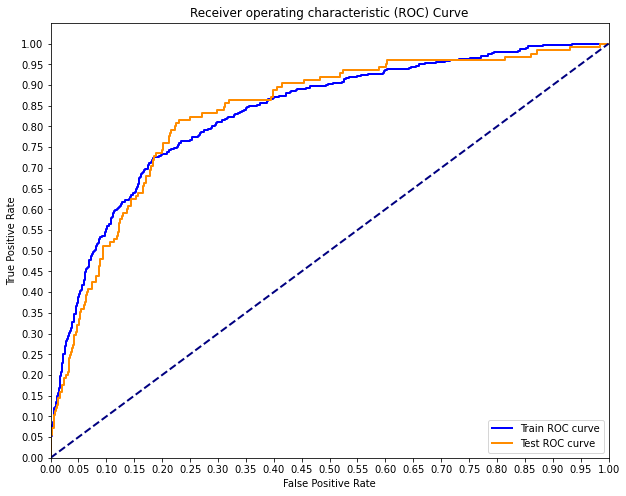

In [38]:
#set up decision scores for the data
y_train_score = logreg.decision_function(X_train)
y_test_score = logreg.decision_function(X_test)

#check the roc curve for the training and testing data
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.figure(figsize=(10, 8))
lw = 2

#graph the ROC curve for the training and testing data to see the results against each other
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [39]:
# Generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

Custom Model Test AUC: 0.5844851904090268
Custome Model Train AUC: 0.5935434546066555


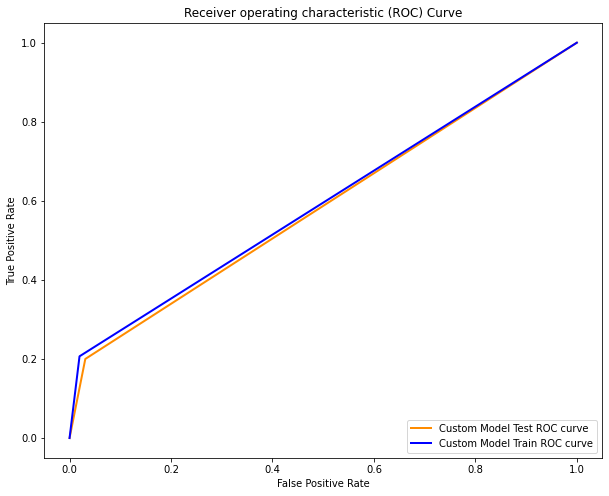

In [40]:
# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train)


print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custome Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The model performs slightly better on the testing data than the training data. 

In [41]:
#Previous original class distribution
print(y_train.value_counts())

#instantiate smote
smote = SMOTE(random_state=STATE)

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

False    2141
True      358
Name: churn, dtype: int64


True     2141
False    2141
Name: churn, dtype: int64


LogisticRegression(C=0.005, fit_intercept=False, random_state=42,
                   solver='liblinear')
AUC for 0.005: 0.7976304654442876
-------------------------------------------------------------------------------------
LogisticRegression(C=0.1, fit_intercept=False, random_state=42,
                   solver='liblinear')
AUC for 0.1: 0.8318533145275034
-------------------------------------------------------------------------------------
LogisticRegression(C=0.2, fit_intercept=False, random_state=42,
                   solver='liblinear')
AUC for 0.2: 0.8345387870239774
-------------------------------------------------------------------------------------
LogisticRegression(C=0.5, fit_intercept=False, random_state=42,
                   solver='liblinear')
AUC for 0.5: 0.8356671368124118
-------------------------------------------------------------------------------------
LogisticRegression(C=0.8, fit_intercept=False, random_state=42,
                   solver='liblinear')
AUC for 0

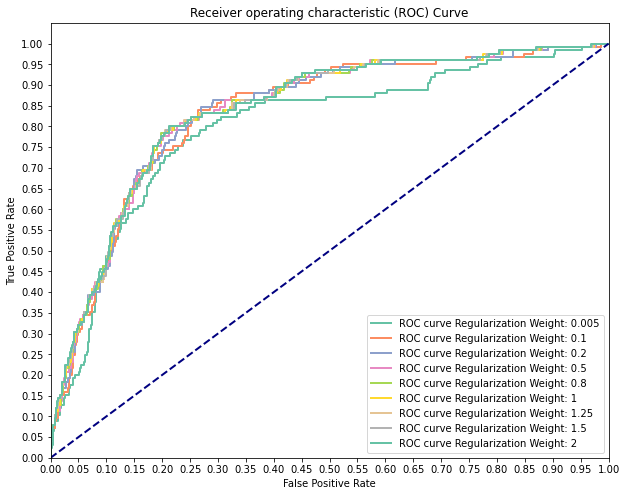

In [42]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

# Write a for loop that builds models for each value of C_param_range, prints the AUC and plots the ROC
for n, c in enumerate(C_param_range):
    # Fit a model 
    logreg = LogisticRegression(fit_intercept=False, C=c, solver ='liblinear', random_state=STATE)
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [43]:
#instantiate tuned model
logreg = LogisticRegression(fit_intercept=False, C=2, solver='liblinear', random_state=STATE)
model_log = logreg.fit(X_train_resampled, y_train_resampled)

#generate predictions
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train_resampled)

#print the scores for metrics
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_hat_test),4))
print('F1 score for testing set: ',round(f1_score(y_test,y_hat_test),4))
print('Recall score for testing set: ',round(recall_score(y_test,y_hat_test),4))
print('Precision score for testing set: ',round(precision_score(y_test,y_hat_test),4))

Accuracy score for testing set:  0.7854
F1 score for testing set:  0.5277
Recall score for testing set:  0.8
Precision score for testing set:  0.3937


Custom Model Test AUC: 0.7913963328631877
Custome Model Train AUC: 0.7891172349369453


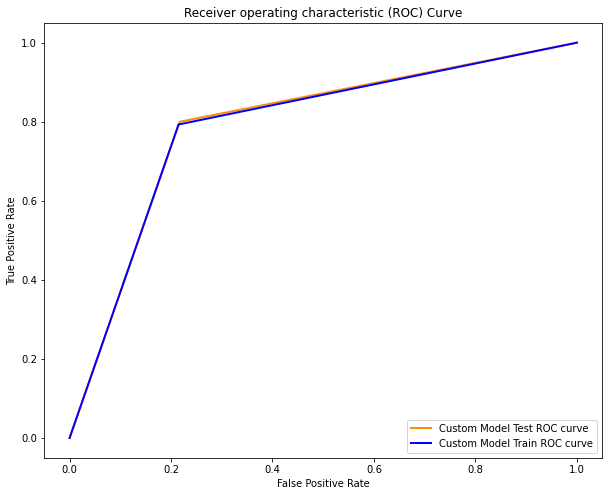

In [44]:
# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_resampled, y_hat_train)


print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custome Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

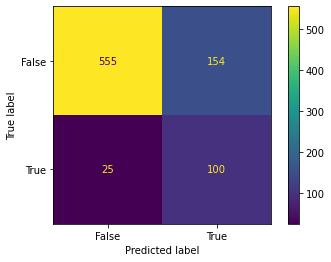

In [45]:
cfm = confusion_matrix(y_test, y_hat_test, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=logreg.classes_)
disp.plot()
plt.show()

In [46]:
tree = DecisionTreeClassifier(random_state=STATE)
tree.fit(X_train_resampled,y_train_resampled)
y_pred_tree = tree.predict(X_test)

In [47]:
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_tree),4))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_tree),4))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_tree),4))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_tree),4))

Accuracy score for testing set:  0.8825
F1 score for testing set:  0.6449
Recall score for testing set:  0.712
Precision score for testing set:  0.5894


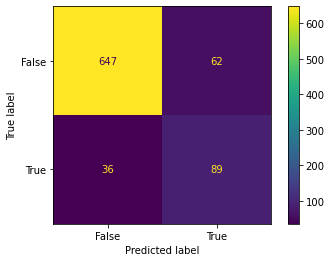

In [48]:
cfm_tree = confusion_matrix(y_test, y_pred_tree, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm_tree, display_labels=tree.classes_)
disp.plot()
plt.show()

Custom Model Test AUC: 0.8122764456981665
Custome Model Train AUC: 1.0


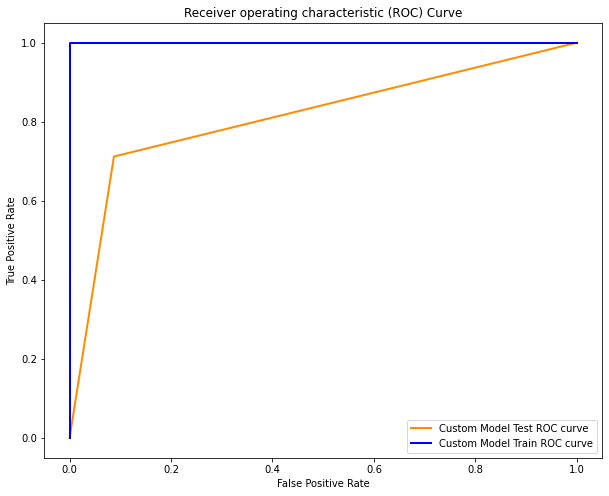

In [49]:
y_tree_train = tree.predict(X_train_resampled)

# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_pred_tree)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_resampled, y_tree_train)


print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custome Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

DecisionTreeClassifier(max_depth=3, random_state=42)
AUC for 3: 0.8433737658674189
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=3.5, random_state=42)
AUC for 3.5: 0.8433737658674189
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=4, random_state=42)
AUC for 4: 0.8129929478138223
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=4.5, random_state=42)
AUC for 4.5: 0.8129929478138223
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=5, random_state=42)
AUC for 5: 0.841675599435825
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=5.5, random_state=42)
AUC for 5.5: 0.841675599435825
--------------------------------------------------------------

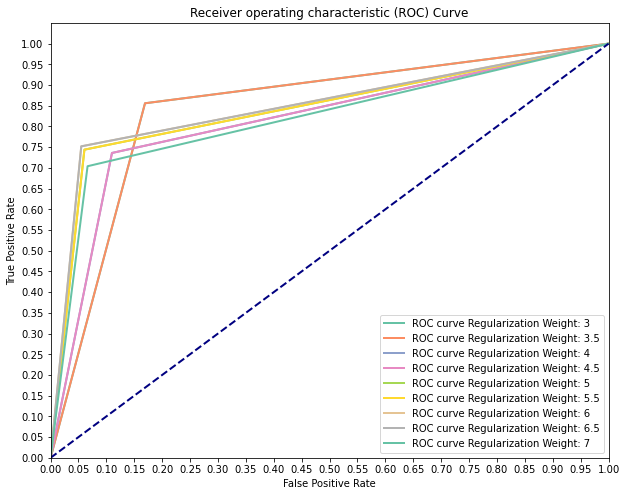

In [50]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
names = [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

# Write a for loop that builds models for each value of C_param_range, prints the AUC and plots the ROC
for n, c in enumerate(C_param_range):
    # Fit a model 
    tree = DecisionTreeClassifier(max_depth=c, random_state=STATE)
    model_log = tree.fit(X_train_resampled, y_train_resampled)
    print(model_log)

    # Predict
    y_hat_test = tree.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_test)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Custom Model Test AUC: 0.8122764456981665
Custome Model Train AUC: 0.9301728164409155


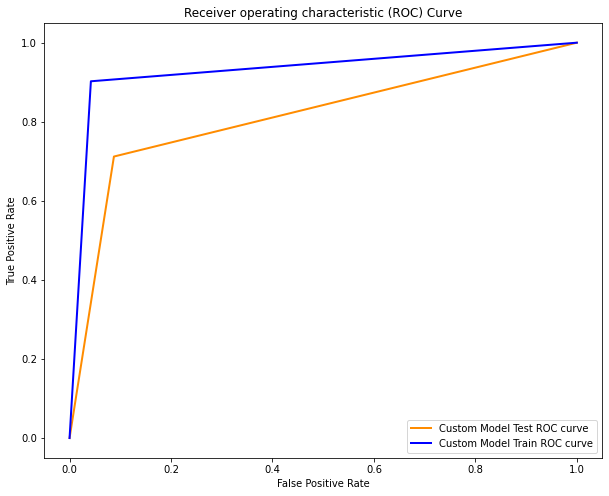

In [51]:
y_tree_train = tree.predict(X_train_resampled)

# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_pred_tree)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_resampled, y_tree_train)


print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custome Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

DecisionTreeClassifier(max_depth=6, min_samples_split=0.5, random_state=42)
AUC for 0.5: 0.820818053596615
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=6, min_samples_split=1.0, random_state=42)
AUC for 1.0: 0.6160225669957686
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=6, random_state=42)
AUC for 2: 0.8484964739069111
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=42)
AUC for 3: 0.8484964739069111
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=6, min_samples_split=4, random_state=42)
AUC for 4: 0.8459069111424542
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=6, min_samples_split=5, random_

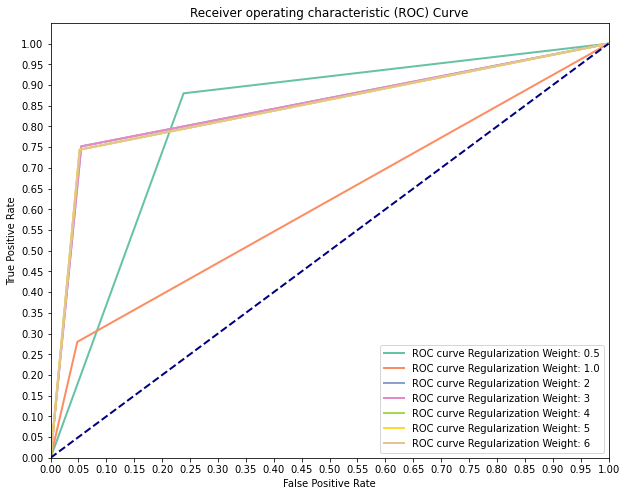

In [52]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.5, 1.0, 2, 3, 4, 5, 6]
names = [0.5, 1.0, 2, 3, 4, 5, 6]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

# Write a for loop that builds models for each value of C_param_range, prints the AUC and plots the ROC
for n, c in enumerate(C_param_range):
    # Fit a model 
    tree = DecisionTreeClassifier(max_depth=6, min_samples_split=c, random_state=STATE)
    model_log = tree.fit(X_train_resampled, y_train_resampled)
    print(model_log)

    # Predict
    y_hat_test = tree.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_test)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

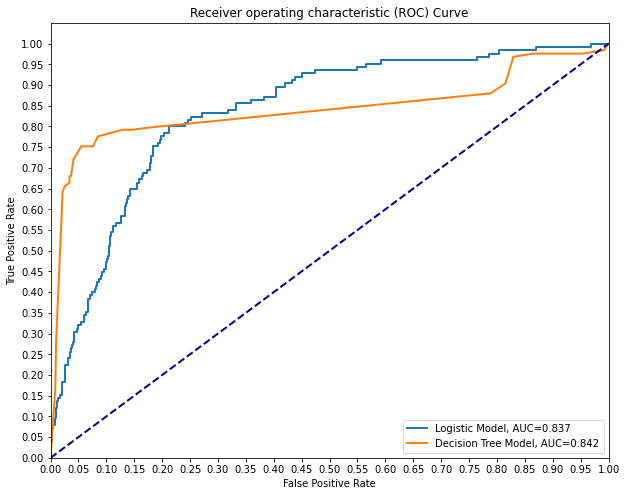

In [53]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=STATE)
tree.fit(X_train_resampled,y_train_resampled)
y_pred_tree = tree.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 8))

y_proba = logreg.predict_proba(X_test)[:, 1]
y_prob = tree.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_prob)


lw = 2
ax.plot(fpr, tpr, lw=lw, label="Logistic Model, AUC={:.3f}".format(auc(fpr, tpr)))
ax.plot(fpr_tree, tpr_tree, lw=lw, label='Decision Tree Model, AUC={:.3f}'.format(auc(fpr_tree, tpr_tree)))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

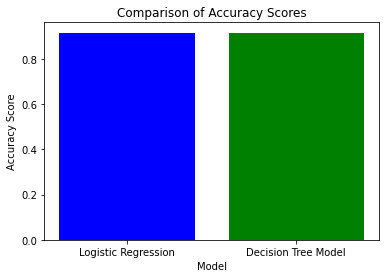

In [54]:
accuracy_scores = [accuracy_score(y_test, y_hat_test), accuracy_score(y_test, y_pred_tree)]
model_names = ['Logistic Regression', 'Decision Tree Model']
# Create a bar graph
plt.bar(model_names, accuracy_scores, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Accuracy Scores')

# Display the bar graph
plt.show()

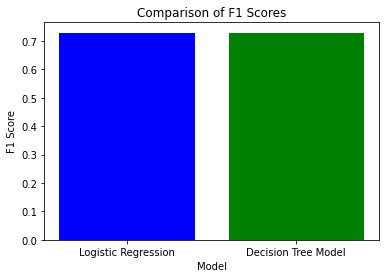

In [55]:
f1_scores = [f1_score(y_test, y_hat_test), f1_score(y_test, y_pred_tree)]

# Create a bar graph
plt.bar(model_names, f1_scores, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores')

# Display the bar graph
plt.show()

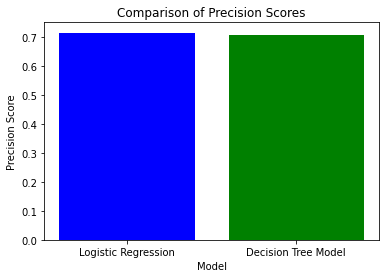

In [56]:
precision_scores = [precision_score(y_test, y_hat_test), precision_score(y_test, y_pred_tree)]

# Create a bar graph
plt.bar(model_names, precision_scores, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Precision Score')
plt.title('Comparison of Precision Scores')

# Display the bar graph
plt.show()

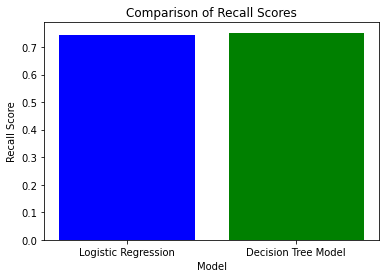

In [57]:
recall_scores = [recall_score(y_test, y_hat_test), recall_score(y_test, y_pred_tree)]

# Create a bar graph
plt.bar(model_names, recall_scores, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Recall Score')
plt.title('Comparison of Recall Scores')

# Display the bar graph
plt.show()